In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array


In [17]:
from pathlib import Path
train_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train')
train_filepaths = list(train_dir.glob('**/*.jpg'))

In [18]:
test_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [19]:
val_dir = Path(r'C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [20]:
from pathlib import Path
import pandas as pd

def image_processing(filepaths):
    """
    Create a DataFrame with the filepaths and the labels of the pictures.
    """
    # Extract labels from the file paths
    labels = [Path(filepath).parent.name for filepath in filepaths]

    # Create a DataFrame
    filepath_series = pd.Series(filepaths, name='Filepath').astype(str)
    label_series = pd.Series(labels, name='Label')
    df = pd.concat([filepath_series, label_series], axis=1)

    # Shuffle the DataFrame and reset the index
    df = df.sample(frac=1).reset_index(drop=True)

    return df


In [21]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [22]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 3397

Number of different labels: 42

Labels: ['soy beans' 'Daisy Fleabane' 'kiwi' 'peas' 'watermelon' 'cucumber'
 'onion' 'corn' 'turnip' 'Asparagus' 'orange' 'tomato' 'pineapple'
 'beetroot' 'Crimson Clover' 'lemon' 'chilli pepper' 'carrot' 'garlic'
 'cauliflower' 'bell pepper' 'jalepeno' 'Fireweed' 'grapes' 'mango'
 'eggplant' 'sweetcorn' 'apple' 'ginger' 'spinach' 'pomegranate'
 'Milk Thistle' 'sweetpotato' 'banana' 'capsicum' 'pear' 'cabbage'
 'paprika' 'Sunflower' 'raddish' 'potato' 'lettuce']


In [23]:
train_df.head(5)

,Filepath,Label
0,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,soy beans
1,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,Daisy Fleabane
2,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,Daisy Fleabane
3,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,kiwi
4,C:\Users\ARIHANT\Desktop\Ingredients Detector\...,peas


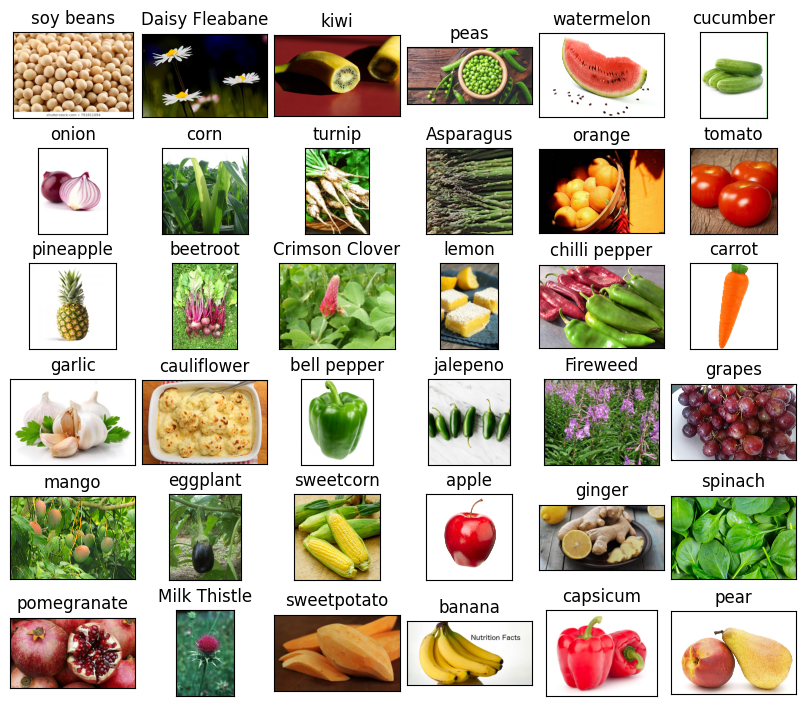

In [24]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [25]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [26]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 3397 validated image filenames belonging to 42 classes.


In [27]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 430 validated image filenames belonging to 42 classes.


In [28]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 430 validated image filenames belonging to 42 classes.


In [29]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [30]:
inputs = pretrained_model.input


x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dropout(0.3)(x)  # Add dropout with 30% rate
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)  # Add dropout again
outputs = tf.keras.layers.Dense(42, activation='softmax')(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

c:\Users\ARIHANT\anaconda3\envs\new_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.1656 - loss: 3.2803 - val_accuracy: 0.8047 - val_loss: 0.8411
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 100s 933ms/step - accuracy: 0.5820 - loss: 1.4307 - val_accuracy: 0.9093 - val_loss: 0.4030
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 927ms/step - accuracy: 0.7145 - loss: 0.9208 - val_accuracy: 0.9116 - val_loss: 0.3171
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 99s 921ms/step - accuracy: 0.7714 - loss: 0.7420 - val_accuracy: 0.9279 - val_loss: 0.2531
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 98s 920ms/step - accuracy: 0.7956 - loss: 0.5970 - val_accuracy: 0.9349 - val_loss: 0.2184
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 98s 914ms/step - accuracy: 0.8310 - loss: 0.5189 - val_accuracy: 0.9395 - val_loss: 0.1801
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 97s 905ms/step - accuracy: 0.8610 - loss: 0.4314 - val_accuracy: 0.9512 - val_loss: 0.1727
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 98s 914ms/step - accuracy: 0.8696 - loss: 0.

In [31]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('model.h5')
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
labels = train_images.class_indices
labels = dict((v, k) for k, v in labels.items())
pred1 = []

for index in pred:
    if index in labels:  
        pred1.append((index, labels[index]))
    else:
        pred1.append((index, "Unknown"))  

for index, label in pred1:
    print(f"Predicted Index: {index}, Predicted Label: {label}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 931ms/step
Predicted Index: 34, Predicted Label: raddish
Predicted Index: 4, Predicted Label: Milk Thistle
Predicted Index: 23, Predicted Label: lemon
Predicted Index: 2, Predicted Label: Daisy Fleabane
Predicted Index: 40, Predicted Label: turnip
Predicted Index: 37, Predicted Label: sweetcorn
Predicted Index: 0, Predicted Label: Asparagus
Predicted Index: 36, Predicted Label: spinach
Predicted Index: 36, Predicted Label: spinach
Predicted Index: 31, Predicted Label: pineapple
Predicted Index: 25, Predicted Label: mango
Predicted Index: 27, Predicted Label: orange
Predicted Index: 17, Predicted Label: eggplant
Predicted Index: 17, Predicted Label: eggplant
Predicted Index: 0, Predicted Label: Asparagus
Predicted Index: 32, Predicted Label: pomegranate
Predicted Index: 10, Predicted Label: cabbage
Predicted Index: 26, Predicted Label: onion
Predicted Index: 36, Predicted Label: spinach
Predicted Index: 8, Predicted Label: beetroot
Predicted Index: 24, Pre

In [32]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

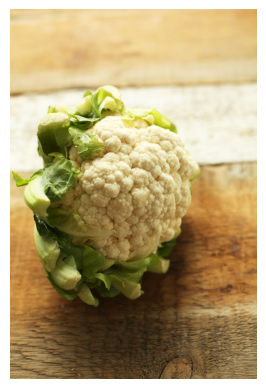

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


'cauliflower'

In [33]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = r"C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train\cauliflower\Image_1.jpg"
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

img = output(r"C:\Users\ARIHANT\Desktop\Ingredients Detector\Dataset\train\cauliflower\Image_1.jpg")
img

In [34]:
model.save('model.h5')

In [35]:
print(train_images.class_indices)

{'Asparagus': 0, 'Crimson Clover': 1, 'Daisy Fleabane': 2, 'Fireweed': 3, 'Milk Thistle': 4, 'Sunflower': 5, 'apple': 6, 'banana': 7, 'beetroot': 8, 'bell pepper': 9, 'cabbage': 10, 'capsicum': 11, 'carrot': 12, 'cauliflower': 13, 'chilli pepper': 14, 'corn': 15, 'cucumber': 16, 'eggplant': 17, 'garlic': 18, 'ginger': 19, 'grapes': 20, 'jalepeno': 21, 'kiwi': 22, 'lemon': 23, 'lettuce': 24, 'mango': 25, 'onion': 26, 'orange': 27, 'paprika': 28, 'pear': 29, 'peas': 30, 'pineapple': 31, 'pomegranate': 32, 'potato': 33, 'raddish': 34, 'soy beans': 35, 'spinach': 36, 'sweetcorn': 37, 'sweetpotato': 38, 'tomato': 39, 'turnip': 40, 'watermelon': 41}


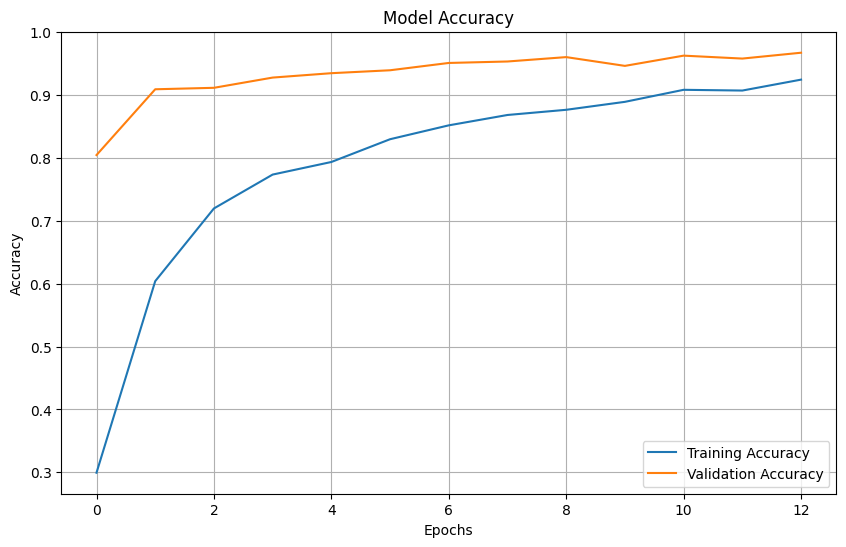

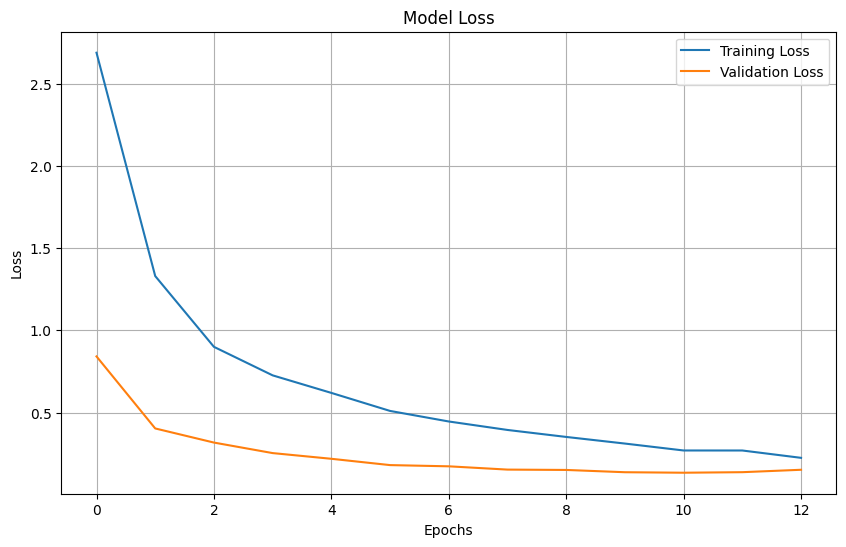

In [36]:
# Plot Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


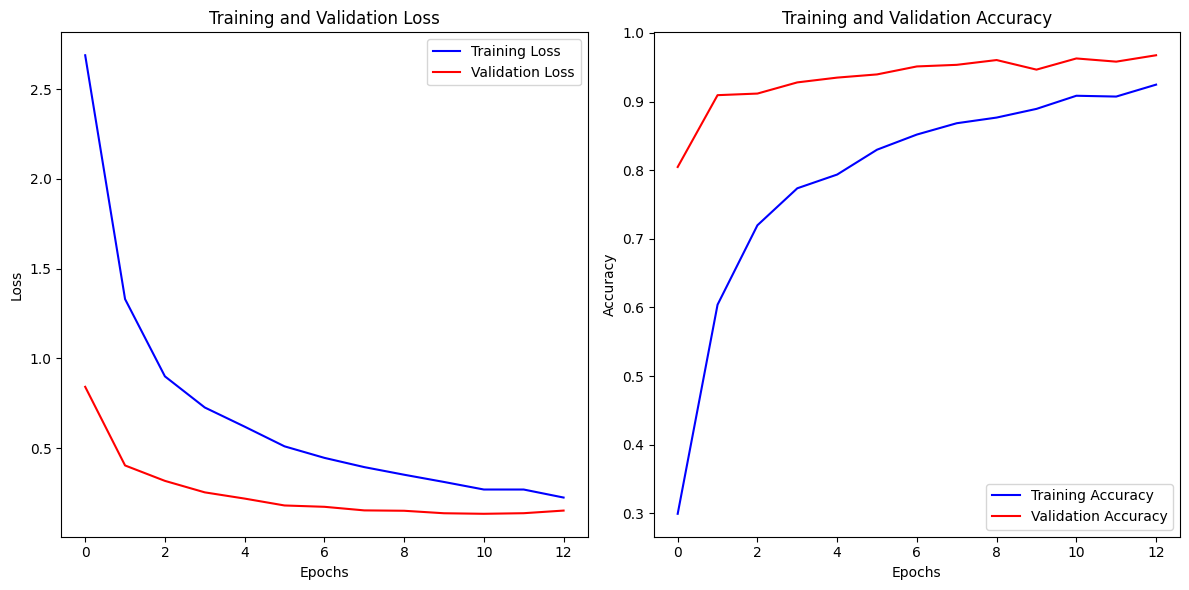

In [37]:
import matplotlib.pyplot as plt

# Training and validation loss
plt.figure(figsize=(12, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [38]:
# Define the class labels based on the dictionary
class_labels = ['Asparagus', 'Crimson Clover', 'Daisy Fleabane', 'Fireweed', 'Milk Thistle', 'Sunflower', 
                'apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 
                'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 
                'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 
                'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 
                'turnip', 'watermelon']

# Plot the heatmap of the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


NameError: name 'conf_matrix' is not defined

<Figure size 1200x800 with 0 Axes>

14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 830ms/step


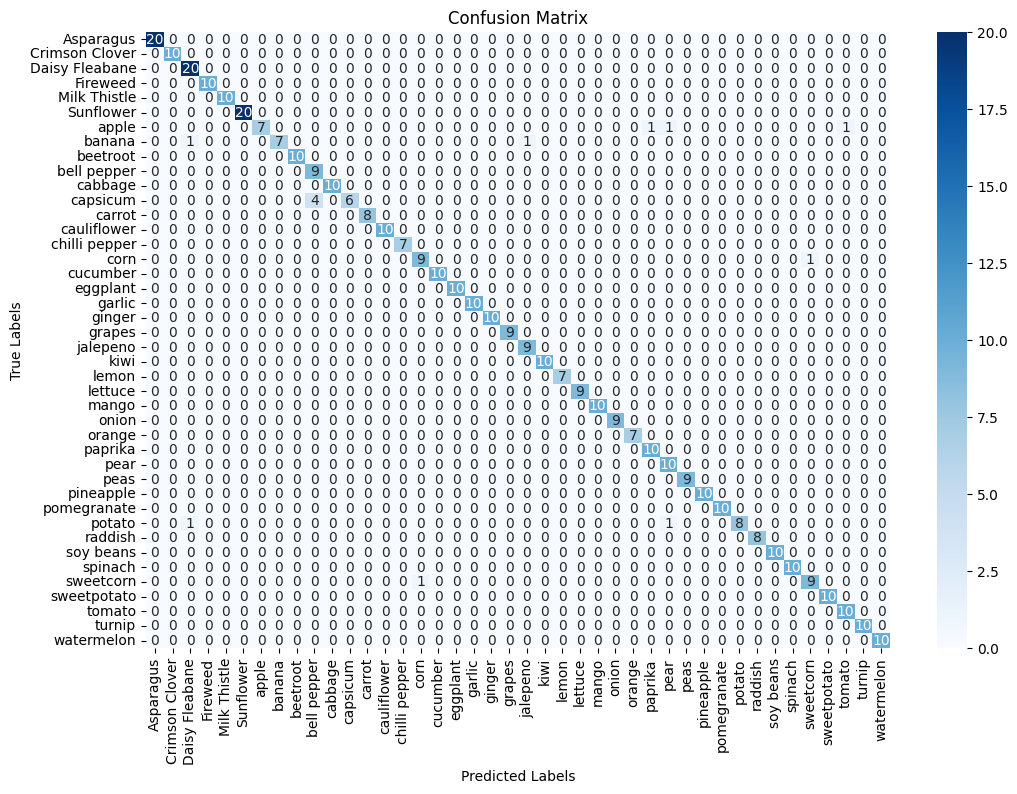

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels for the test dataset
true_labels = test_images.classes

# Get predictions from the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Get the class labels
class_labels = list(train_images.class_indices.keys())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='MobileNetV2 Train Accuracy')
plt.plot(history.history['val_accuracy'], label='MobileNetV2 Validation Accuracy')
plt.plot(history2.history['accuracy'], label='InceptionV3 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='InceptionV3 Validation Accuracy')
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='MobileNetV2 Train Loss')
plt.plot(history.history['val_loss'], label='MobileNetV2 Validation Loss')
plt.plot(history2.history['loss'], label='InceptionV3 Train Loss')
plt.plot(history2.history['val_loss'], label='InceptionV3 Validation Loss')
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
